# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from functools import partial
import sklearn

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
gs_path = Path('./GS')
gs_path.absolute(), gs_path.exists()

(PosixPath('/home/ubuntu/off-sample/GS'), True)

# Load and Prepare Data

In [5]:
non_rect_ds_names = {
    'HK_S2_N2_20um_New', '12_cylces_75um_new_submission',
    '50um_min(focusing)_high(m_z)_dry(application)', '100um_noM2_001_Recal', '50%meoh_8cyc_75um',
    'Servier_Ctrl_mouse_wb_lateral_plane_DHB','75um_small(focusing)_high(m_z)_dry(application)',
    'Servier_Ctrl_rat_liver_9aa', 'servier_TT_mouse_wb_fmpts_derivatization_CHCA',
    'Servier_Ctrl_mouse_wb_median_plane_9aa', '20171110_94T_RDAM_1b',
    'Servier_Ctrl_mouse_wb_median_plane_DHB', 'slide077_animal121_rat_kidney - total ion count',
    '170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r', '70%meoh_8cyc_75um',
    '75um_small(focusing)_low(m_z)_dry(application)', 'slide012_animal102_minipig_kidney- total ion count'}

### Classify Using Basic Features

In [6]:
gs_df = pd.read_csv('GS.csv')
gs_df.head()

,Unnamed: 0,datasetId,dsName,sumFormula,adduct,type
0,23322,2016-09-21_16h07m21s,UoNotreDame//Untreated_6_574,C10H11NO,+Na,on
1,23323,2016-09-21_16h07m21s,UoNotreDame//Untreated_6_574,C7H15NO2,+K,on
2,23324,2016-09-21_16h07m21s,UoNotreDame//Untreated_6_574,C8H17NO2,+K,on
3,23325,2016-09-21_16h07m21s,UoNotreDame//Untreated_6_574,C11H8O3,+H,off
4,23326,2016-09-21_16h07m21s,UoNotreDame//Untreated_6_574,C11H6O3,+H,off


In [7]:
gs_df.groupby(['adduct', 'type']).sumFormula.count()

adduct  type
+Cl     off      375
        on      1087
+H      off     2665
        on      2806
+K      off     2705
        on      2858
+Na     off     2634
        on      2834
-H      off     1530
        on      3744
Name: sumFormula, dtype: int64

In [8]:
meta_df = pd.DataFrame()
# meta_df['target'] = (df.type == 'off').astype(int)
meta_df['negative_mode'] = gs_df.adduct.isin(['-H', '+Cl']).astype(int)
# features_df['adduct'] = df.adduct
meta_df['formula_len'] = gs_df.sumFormula.map(len)
meta_df = meta_df.join(pd.get_dummies(gs_df.adduct))
meta_df['rect'] = gs_df.dsName.map(lambda name: name.replace('/', '_') not in non_rect_ds_names).astype(int)
meta_df.head()

,negative_mode,formula_len,+Cl,+H,+K,+Na,-H,rect
0,0,8,0,0,0,1,0,1
1,0,8,0,0,1,0,0,1
2,0,8,0,0,1,0,0,1
3,0,7,0,1,0,0,0,1
4,0,7,0,1,0,0,0,1


In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
X = meta_df.values
y = (gs_df.type == 'off').astype(int).values
X.shape, y.shape

((23238, 8), (23238,))

In [11]:
n = X.shape[0]
val_size = int(n * 0.2)
n, val_size

(23238, 4647)

In [12]:
inds = np.arange(X.shape[0])
np.random.shuffle(inds)
train_inds, val_inds = inds[:-val_size], inds[-val_size:]
train_inds.shape, val_inds.shape

((18591,), (4647,))

In [13]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X[train_inds], y[train_inds])
clf.score(X[val_inds], y[val_inds])

0.6673122444587907

In [14]:
from sklearn.metrics import roc_auc_score, f1_score

In [15]:
y_pred_prob = clf.predict_proba(X[val_inds])[:,1]
y_pred = clf.predict(X[val_inds])
(roc_auc_score(y_true=y[val_inds], y_score=y_pred_prob),
 f1_score(y_true=y[val_inds], y_pred=y_pred))

(0.7096687265635349, 0.5590416428978894)

In [16]:
y_pred.sum(), y_pred.shape

(1562, (4647,))

## Doulble check GS images

In [17]:
gs_df = pd.read_csv('GS.csv')[['dsName', 'sumFormula', 'adduct', 'type']]
gs_df['dsName'] = gs_df.dsName.map(lambda name: name.replace('/', '_'))
gs_df['ion'] = gs_df.sumFormula + gs_df.adduct
gs_df.drop(labels=['sumFormula', 'adduct'], axis=1, inplace=True)
gs_df.sort_values(by=['dsName', 'type', 'ion'], inplace=True)
gs_df.reset_index(drop=True, inplace=True)
gs_df.head()

,dsName,type,ion
0,100um_noM2_001_Recal,off,C14H20N6O5S+H
1,100um_noM2_001_Recal,off,C15H19NO10+H
2,100um_noM2_001_Recal,off,C15H26N2O12+H
3,100um_noM2_001_Recal,off,C16H16O11S+Na
4,100um_noM2_001_Recal,off,C16H19N3O5S+H


In [18]:
# pd.Series(gs_df.dsName.unique()).to_csv('gs_ds_names.csv', index=False)

In [19]:
rows = []
for ds_path in gs_path.iterdir():
    ds_name = ds_path.name
    for t in ['on', 'off']:
        for image_path in (ds_path / t).iterdir():
            ion = image_path.name.split('.')[0]
            rows.append([ds_name, t, ion])
iso_image_df = (pd.DataFrame(rows, columns=['dsName', 'type', 'ion'])
                .sort_values(by=['dsName', 'type', 'ion'])
                .reset_index(drop=True))

In [20]:
np.all(gs_df == iso_image_df)

True

## Check Non-rect Datasets

In [21]:
len(non_rect_ds_names)

17

In [22]:
katya_nonrect_ds_names = \
'''UoNotreDame//Untreated_6_574
MPIMM_021_QE_P_CB_0
MP 39
ICL//LNTO31_17_4
170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r
20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N
Servier_Ctrl_rat_liver_9aa
servier_TT_mouse_wb_fmpts_derivatization_CHCA
slide077_animal121_rat_kidney - total ion count
slide012_animal102_minipig_kidney- total ion count
100um_noM2_001_Recal
Servier_Ctrl_mouse_wb_median_plane_9aa
Servier_Ctrl_mouse_wb_lateral_plane_DHB
Servier_Ctrl_mouse_wb_median_plane_DHB
20171110_94T_RDAM_1b
75um_small(focusing)_high(m/z)_dry(application)
75um_small(focusing)_low(m/z)_dry(application)
50um_min(focusing)_high(m/z)_dry(application)
12_cylces_75um_new_submission
50%meoh_8cyc_75um
70%meoh_8cyc_75um
HK_S2_N2_20um_New
PS_7_P7_N1_30um_New'''.replace('/', '_').split('\n')
katya_nonrect_ds_names

['UoNotreDame__Untreated_6_574',
 'MPIMM_021_QE_P_CB_0',
 'MP 39',
 'ICL__LNTO31_17_4',
 '170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r',
 '20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N',
 'Servier_Ctrl_rat_liver_9aa',
 'servier_TT_mouse_wb_fmpts_derivatization_CHCA',
 'slide077_animal121_rat_kidney - total ion count',
 'slide012_animal102_minipig_kidney- total ion count',
 '100um_noM2_001_Recal',
 'Servier_Ctrl_mouse_wb_median_plane_9aa',
 'Servier_Ctrl_mouse_wb_lateral_plane_DHB',
 'Servier_Ctrl_mouse_wb_median_plane_DHB',
 '20171110_94T_RDAM_1b',
 '75um_small(focusing)_high(m_z)_dry(application)',
 '75um_small(focusing)_low(m_z)_dry(application)',
 '50um_min(focusing)_high(m_z)_dry(application)',
 '12_cylces_75um_new_submission',
 '50%meoh_8cyc_75um',
 '70%meoh_8cyc_75um',
 'HK_S2_N2_20um_New',
 'PS_7_P7_N1_30um_New']

In [23]:
set(non_rect_ds_names) - (set(katya_nonrect_ds_names))

set()

In [24]:
(set(katya_nonrect_ds_names)) - set(non_rect_ds_names)

{'20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N',
 'ICL__LNTO31_17_4',
 'MP 39',
 'MPIMM_021_QE_P_CB_0',
 'PS_7_P7_N1_30um_New',
 'UoNotreDame__Untreated_6_574'}

## Prepare Dataframe for Fastai Loader

In [27]:
len(list(gs_path.iterdir()))

87

In [28]:
row_list = []
for ds_path in gs_path.iterdir():
    for cl in ['on', 'off']:
        for p in (ds_path / cl).iterdir():
            row_list.append([str(p), ds_path.name, cl])

df = pd.DataFrame(row_list, columns=['name', 'group', 'label'])
df.shape

(23238, 3)

In [29]:
df.head()

,name,group,label
0,GS/DESI quan_Swales/on/C21H43O6P+H.png,DESI quan_Swales,on
1,GS/DESI quan_Swales/on/C4H7O8P+Na.png,DESI quan_Swales,on
2,GS/DESI quan_Swales/on/C21H39O7P+H.png,DESI quan_Swales,on
3,GS/DESI quan_Swales/on/C10H11NO3+Na.png,DESI quan_Swales,on
4,GS/DESI quan_Swales/on/C24H40O4+Na.png,DESI quan_Swales,on


In [30]:
all_groups = list(df.group.unique())
print(len(all_groups))

87


In [31]:
df['rect'] = df.group.map(lambda g: g not in non_rect_ds_names)

In [32]:
df.groupby(['rect', 'label']).name.count()

rect   label
False  off       1409
       on        2724
True   off       8500
       on       10605
Name: name, dtype: int64

In [33]:
# df = df[df.rect == True]

# Visualize Images in Low Dimentionality 

In [80]:
# df

In [163]:
# ds_name = 'DESI quan_Swales'
ds_name = list(non_rect_ds_names)[6]
ds_name, df[df.group == ds_name].shape

('100um_noM2_001_Recal', (434, 4))

In [164]:
labels = (df[df.group == ds_name].label == 'off').astype(int).values
labels.shape

(434,)

In [165]:
pd.value_counts(labels)

0    336
1     98
dtype: int64

In [166]:
fnames = df[df.group == ds_name].name.values
# fnames

In [167]:
from PIL import Image

def read_image(fname):
    return np.array(Image.open(open(fname, 'rb')))[:,:,0]

In [168]:
n = len(fnames)
sample_image = read_image(fnames[-1])
row, cols = sample_image.shape
row, cols

(119, 254)

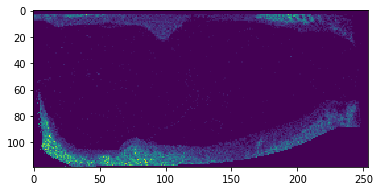

In [169]:
plt.imshow(sample_image)

In [170]:
X = np.zeros((n, row * cols))
for i, fname in enumerate(fnames):
    image = read_image(fname).flatten()
    X[i] = image
X.shape

(434, 30226)

In [189]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3)
X_embed = tsne.fit_transform(X)
X_embed.shape

(434, 3)

In [191]:
# fig, axes = plt.subplots(nrows=3, figsize=(12, 6*3))
# for i, (c1, c2) in enumerate([(0, 1), (0, 2), (1, 2)]):
#     axes[i].scatter(X_embed[:,c1], X_embed[:,c2], c=labels, alpha=0.5);

In [173]:
import umap

In [186]:
X_embed = umap.UMAP(n_neighbors=10, n_components=3).fit_transform(X)
X_embed.shape

(434, 3)

In [192]:
# fig, axes = plt.subplots(nrows=3, figsize=(12, 6*3))
# for i, (c1, c2) in enumerate([(0, 1), (0, 2), (1, 2)]):
#     axes[i].scatter(X_embed[:,c1], X_embed[:,c2], c=labels, alpha=0.5);

## Cross-validation Folds

In [32]:
from sklearn.model_selection import GroupKFold

In [33]:
group_folds = []
cv_iter = GroupKFold(n_splits=5).split(df.name, groups=df.group)
for fold_i, (t_inds, v_inds) in enumerate(cv_iter):
    valid_groups = df.iloc[v_inds].group.unique().tolist()
    group_folds.append(valid_groups)

In [34]:
group_folds

[['50%meoh_8cyc_75um',
  'Dataset 31',
  'Servier_Ctrl_mouse_wb_median_plane_DHB',
  'slide012_animal102_minipig_kidney- total ion count',
  'servier_TT_mouse_wb_fmpts_derivatization_CHCA',
  '20180220_mouse eye_DHB',
  'xenograft CT-26 S10',
  '170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r',
  'Servier_Ctrl_mouse_wb_median_plane_9aa',
  '2017023_ADP_GFlarvae_55x55_40x40_DMAN002',
  '161007_WT1S1L1',
  'DESI porcine kidney interface region',
  'ICL__LNTO42_17_1',
  'Dataset 26_recal',
  'ICL__LNTO41_17_4',
  'ICL__LNTO30_16_1',
  'LNTO31_17_1-RECAL'],
 ['20170817_CGL_MT-M.B_ATP_DAN018_NTM_102x39_100x100',
  'MP 39',
  'NCSU_M8_mouse_brain',
  'AstraZeneca__CT26_xenograft',
  '50um_min(focusing)_high(m_z)_dry(application)',
  'Dataset 4',
  '20170905_CGL0170817_MT-MB_ATP_N_81x101_135x135',
  'Mouse Kidney on coated plastic slide 270x160 30 um',
  'UoNotreDame__Untreated_6_574',
  '20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N',
  'Dataset 4_recal',
  '20170815_CGL_MT-M.B_DAN012_NTM_

## Define Metrics

In [36]:
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score, accuracy_score

def convert_to_2dim(y):
    y_ = y
    if y.ndim < 2:
        y_ = np.zeros(shape=(y.shape[0], 2))
        y_[:,0] = 1 - y
        y_[:,1] = y
    return y_

def calc_metrics(y_true, y_pred):
    y_true = convert_to_2dim(y_true)
    y_pred = convert_to_2dim(y_pred)

    y_pred_lab = (y_pred > 0.5).astype(int)
    metrics = []
    classes = [(0, 'on'), (1, 'off')]
    for i, cl in classes:
        metrics.append(OrderedDict({
            'f1': f1_score(y_true[:,i], y_pred_lab[:,i]),
            'prec': precision_score(y_true[:,i], y_pred_lab[:,i]),
            'recall': recall_score(y_true[:,i], y_pred_lab[:,i]),
            'acc': accuracy_score(y_true[:,i], y_pred_lab[:,i]),
        }))
    return pd.DataFrame(metrics, index=['on', 'off'])

def calc_ds_metrics(valid_df, y_true, y_pred):
    _df = valid_df.copy()
    _df['y_true'] = y_true
    _df['y_pred'] = y_pred[:,1]

    rows = []
    for ds_name, ds_df in _df.groupby('group'):
        m = calc_metrics(ds_df['y_true'], ds_df['y_pred'])
        m['ds_name'] = ds_name
        rows.append(m)
    return pd.concat(rows)

# Two Inputs Experiments

In [37]:
test_groups = group_folds[2]
test_groups

['DESI quan_Swales',
 '20171110_94T_RDAM_1b',
 'Servier_Ctrl_rat_liver_9aa',
 'AstraZeneca__Rat_testis',
 'North Carolina State University__mouse body',
 'BRB04S-RECAL',
 'Row001',
 '100um_noM2_001_Recal',
 'Servier_Ctrl_mouse_wb_lateral_plane_DHB',
 'Xenograft_3_135um',
 'Dataset 30',
 'PS_7_P7_N1_30um_New',
 '75um_small(focusing)_low(m_z)_dry(application)',
 'Dataset 27',
 'Dataset 21',
 'Esco1_centroids',
 'ICL__LNTO41_17_2',
 'ST-Pseudo_centroids']

In [38]:
df.head()

,name,group,label,rect
0,GS/DESI quan_Swales/on/C21H43O6P+H.png,DESI quan_Swales,on,True
1,GS/DESI quan_Swales/on/C4H7O8P+Na.png,DESI quan_Swales,on,True
2,GS/DESI quan_Swales/on/C21H39O7P+H.png,DESI quan_Swales,on,True
3,GS/DESI quan_Swales/on/C10H11NO3+Na.png,DESI quan_Swales,on,True
4,GS/DESI quan_Swales/on/C24H40O4+Na.png,DESI quan_Swales,on,True


In [39]:
def train_valid_test(df, test_groups):
    cv = sklearn.model_selection.GroupKFold(n_splits=4)
    train_inds, valid_inds = next(cv.split(df[~df.group.isin(test_groups)].group,
                                           groups=df[~df.group.isin(test_groups)].group))
    test_inds = df[df.group.isin(test_groups)].index.values
    return train_inds, valid_inds, test_inds

In [40]:
def build_data(df, train_inds, valid_inds):
    src = (ImageItemList.from_df(df, '', cols=0)
           .split_by_idxs(train_inds, valid_inds)
           .label_from_df(cols=2))
    tfms = get_transforms(flip_vert=True, max_rotate=15)

    data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
            .databunch()
            .normalize(imagenet_stats))
    return data

In [41]:
train_inds, valid_inds, test_inds = train_valid_test(df, test_groups)
train_inds.shape, valid_inds.shape, test_inds.shape

((13932,), (4640,), (4666,))

In [218]:
data_ = build_data(df, train_inds, valid_inds)

In [222]:
data_.train_ds.y.classes

['off', 'on']

In [42]:
# class ImageMeta(Image):
#     def __init__(self, img, meta):
#         self.img = img
#         self.meta = meta
#         self.obj = (img, meta)
#         self.data = [img.data, meta]
    
#     def apply_tfms(self, tfms, **kwargs):
#         self.img = self.img.apply_tfms(tfms, **kwargs)
#         self.data = [self.img.data, self.meta]
#         return self
    
#     @property
#     def device(self):
#         return self.img.device
    
#     def __repr__(self):
#         return f'{self.__class__.__name__} - img:{tuple(self.img.shape)}, meta:{self.meta}\n'

In [43]:
# class ImageMetaList(ImageItemList):
#     def __init__(self, items, meta_items=None, **kwargs):
#         super().__init__(items, **kwargs)
#         self.meta_items = meta_items

#     def new(self, items, **kwargs):
#         return super().new(items, meta_items=self.meta_items, **kwargs)
    
#     def get(self, i):
#         img = super().get(i)
#         meta = self.meta_items[i]
#         return ImageMeta(img, meta)
    
#     @classmethod
#     def from_dfs(cls, df, meta_df, **kwargs):
#         res = super().from_df(df, path='.', **kwargs)
#         res.meta_items = meta_df.values
#         return res

In [44]:
# src = (ImageMetaList.from_dfs(df, meta_df)
#        .split_by_idxs(train_inds, valid_inds)
#        .label_from_df(cols=2))

In [45]:
# tfms = get_transforms(flip_vert=True, max_rotate=15)
# src = src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
# data = src.databunch().normalize(imagenet_stats)

In [223]:
class ImageMetaDataset(Dataset):
    def __init__(self, image_fns, meta_arr, labels, classes=None, tfms=None, tfmargs=None):
        super().__init__()
        self.image_fns = image_fns
        self.labels = labels
        self.meta_arr = torch.from_numpy(meta_arr.astype(np.float32))
        if not classes:
            classes = ['on', 'off']
        self.classes = sorted(classes)
        self.c = len(classes)
        self.tfms = tfms
        self.tfmargs = tfmargs
        
    def __getitem__(self, i):
        image = open_image(self.image_fns[i])
        image_t = image.apply_tfms(self.tfms, **self.tfmargs).data
        
        meta = self.meta_arr[i]
        label = self.classes.index(self.labels[i])
#         return (image_t, meta), label
        return image_t, label
    
    def __len__(self):
        return len(self.image_fns)

In [224]:
train_tfms, valid_tfms = get_transforms(flip_vert=True, max_rotate=15)
tfmargs = dict(size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')

train_ds = ImageMetaDataset(image_fns=df.loc[train_inds].name.values,
                            meta_arr=meta_df.loc[train_inds].values,
                            labels=df.loc[train_inds].label.values,
                            tfms=train_tfms, tfmargs=tfmargs)
valid_ds = ImageMetaDataset(image_fns=df.loc[valid_inds].name.values,
                            meta_arr=meta_df.loc[valid_inds].values,
                            labels=df.loc[valid_inds].label.values,
                            tfms=valid_tfms, tfmargs=tfmargs)
len(train_ds), len(valid_ds)

(13932, 4640)

In [225]:
# image = train_ds[-10][0]
# for ch in range(3):
#     plt.imshow(image[ch,:,:])
#     plt.show()

In [243]:
batch_size = 64
data = ImageDataBunch(train_dl=DataLoader(train_ds, batch_size, shuffle=True),
                      valid_dl=DataLoader(valid_ds, batch_size*2, shuffle=False)).normalize(imagenet_stats)

In [244]:
tr = data.train_ds
tr_ = data_.train_ds

In [245]:
len(tr), len(tr_)

(13932, 13932)

1


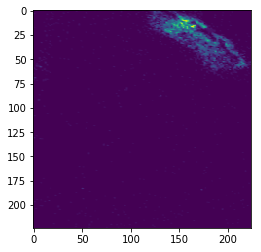

In [246]:
image, label = tr[-10]
print(label)
plt.imshow(image[0,:,:]);

on 1


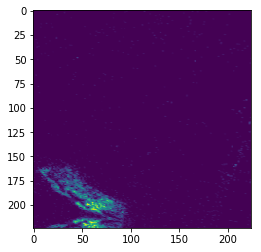

In [247]:
image, label = tr_[-10]
print(label, label.data)
plt.imshow(image.data[0,:,:]);

In [248]:
data.classes, data_.classes

(['off', 'on'], ['off', 'on'])

In [249]:
# def build_mixed_data(df, meta_df, train_inds, valid_inds):
#     image_itemlist = ImageItemList.from_df(df, '', cols=0)
#     meta_itemlist = ItemList(meta_df)
#     itemlists = (ItemList(zip(image_itemlist, meta_itemlist))
#                  .split_by_idxs(train_inds, valid_inds))
#     labels = ItemLists('', train=ItemList(df.label.values[train_inds]),
#                        valid=ItemList(df.label.values[valid_inds]))
#     train_itemlabel = LabelList(itemlists.train, labels.train)
#     valid_itemlabel = LabelList(itemlists.valid, labels.valid)
#     labellists = LabelLists('', train=train_itemlabel, valid=valid_itemlabel)
    
#     tfms = get_transforms(flip_vert=True, max_rotate=15)

#     data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
#             .databunch()
#             .normalize(imagenet_stats))
#     return data

In [250]:
meta_feature_n = meta_df.shape[1]
meta_feature_n

8

In [251]:
from fastai.callbacks import *

In [252]:
class MetaModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(input_size)
#         self.dropout_1 = nn.Dropout(dropout_ps[0])
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
#         self.dropout_2 = nn.Dropout(p=dropout_ps[1])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.bn1(x)
#         x = self.dropout_1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
#         x = self.dropout_2(x)
        x = F.relu(self.fc2(x))
        return x

class MixedInputModel(nn.Module):
    def __init__(self, meta_input_size, meta_output_size=32):
        super().__init__()
        self.conv = create_body(arch=models.resnet50, pretrained=True)  # output: 4096x1
#         self.meta = MetaModel(meta_input_size, 128, meta_output_size)
        head_input_size = num_features_model(self.conv) + meta_output_size
        self.head = create_head(nf=head_input_size*2, nc=2,
                                ps=0, lin_ftrs=[512])  # skip adaptive pooling and flatten
    
    def forward(self, img_x, meta_x):
        img_out = self.conv(img_x)
#         meta_out = self.meta(meta_x)
#         x = torch.cat([img_out.view(img_out.shape[0], -1)], -1)
        out = self.head(img_out)
        return out

In [253]:
model = MixedInputModel(meta_input_size=meta_feature_n, meta_output_size=0)

In [254]:
for l in model.conv:
    for p in l.parameters():
        p.requires_grad = False

In [255]:
apply_init(model.head, nn.init.kaiming_normal_)

In [256]:
# from numpy import linalg as LA
# for lp in model.conv.parameters():
#     print(LA.norm(lp.flatten()), lp.shape)

In [257]:
# learn = Learner(data, model, metrics=[accuracy])
data_ = build_data(df, train_inds, valid_inds)

In [258]:
arch = models.resnet50
learn = create_cnn(data, arch, metrics=[accuracy], ps=0.5)

lr = 3e-3
learn.fit_one_cycle(5, slice(lr), wd=0.)

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

In [30]:
learn.save(f'gs-{arch.__name__}-stage1.fai')

In [31]:
len(data.train_dl.dataset)

13932

In [389]:
# learn.load(f'gs-{arch.__name__}-stage1.fai');

In [388]:
# learn.unfreeze()
# div = 10
# learn.fit_one_cycle(5, slice(1e-6, lr/div), wd=0.1)

In [32]:
# learn.validate(data.train_dl),
learn.validate(data.valid_dl)

[0.091364056, tensor(0.9666)]

In [408]:
# test_data = build_data(df, train_inds, test_inds)
# learn.validate(test_data.valid_dl)

In [152]:
# learn.model

In [33]:
learn.data.classes

['off', 'on']

In [172]:
conv_layers, classifier = learn.model

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [65]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x):
        x = torch.cat([self.avg_pool(x), self.max_pool(x)], dim=1)
        return x.view(x.size(0), -1)

In [66]:
feature_extract_learn = Learner(data, nn.Sequential(conv_layers, FeatureExtractor()))
feature_extract_learn.model.eval();

In [136]:
train_features_list = []
m = 3
for i in range(m):
    train_features, _ = feature_extract_learn.get_preds(DatasetType.Train)
    train_features_list.append(train_features)
train_features = torch.cat(train_features_list)
train_features.shape, len(feature_extract_learn.data.train_dl.dataset)

RuntimeError: expected a non-empty list of Tensors

In [174]:
valid_features, _ = feature_extract_learn.get_preds(DatasetType.Valid)
valid_features.shape, len(feature_extract_learn.data.valid_dl.dataset)

(torch.Size([4640, 4096]), 4640)

In [175]:
valid_features2, _ = feature_extract_learn.get_preds(DatasetType.Valid)
valid_features2.shape

torch.Size([4640, 4096])

In [176]:
valid_features[0, :10]

tensor([8.4386e-06, 1.1569e-05, 7.4853e-06, 7.2389e-06, 1.1994e-05, 7.5875e-06,
        9.8710e-06, 7.8183e-06, 1.0943e-05, 7.3366e-06])

In [177]:
valid_features2[0, :10]

tensor([8.4386e-06, 1.1569e-05, 7.4853e-06, 7.2389e-06, 1.1994e-05, 7.5875e-06,
        9.8710e-06, 7.8183e-06, 1.0943e-05, 7.3366e-06])

In [70]:
# learn.data = test_data
# test_features, _ = learn.get_preds(DatasetType.Valid)
# test_features.shape, len(learn.data.valid_dl.dataset)

In [138]:
def convert_labels_to_inds(df, inds):
    a = (df.iloc[inds].label == 'on').astype(int).values
    return torch.tensor(a)

In [142]:
train_y_list = []
for i in range(m):
    train_y = convert_labels_to_inds(df, train_inds)[:train_features.shape[0] // m]
    train_y_list.append(train_y)
train_y = torch.cat(train_y_list)
    
valid_y = convert_labels_to_inds(df, valid_inds)
# test_y = convert_labels_to_inds(df, test_inds)
train_y.shape, valid_y.shape, #test_y.shape

(torch.Size([41664]), torch.Size([4640]))

In [143]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import time

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [145]:
train_features_ds = TensorDataset(train_features, train_y)
valid_features_ds = TensorDataset(valid_features, valid_y)
# test_features_ds = TensorDataset(test_features, test_y)

In [146]:
bs = 64
train_features_dl = DataLoader(train_features_ds, batch_size=bs, shuffle=True)
valid_features_dl = DataLoader(valid_features_ds, batch_size=bs*2, shuffle=False)
# test_features_dl = DataLoader(test_features_ds, batch_size=bs*2, shuffle=False)

In [147]:
class ExtraFeaturesClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, dropout_ps):
        super().__init__()
        self.batch_norm_1 = nn.BatchNorm1d(input_size)
        self.dropout_1 = nn.Dropout(dropout_ps[0])
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.batch_norm_2 = nn.BatchNorm1d(hidden_size)
        self.dropout_2 = nn.Dropout(p=dropout_ps[1])
        self.linear_2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.batch_norm_1(x)
        x = self.dropout_1(x)
        x = F.relu(self.linear_1(x))
        x = self.batch_norm_2(x)
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [167]:
model = ExtraFeaturesClassifier(input_size=4096, hidden_size=512, dropout_ps=[0.5, 0.5])
# model = learn.classifier[2:]
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
# optimizer = SGD(model.parameters(), lr=0.03, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [168]:
np.sum([t.flatten().shape for t in model.parameters()])

2107906

In [169]:
def valid_step(model, dl, criterion):
    running_loss, running_corrects = 0.0, 0.0
    model.eval()
    with torch.no_grad():
        for xs, ys in dl:
#             print('.', end='')
            xs = xs.to(device)
            ys = ys.to(device)
            
            outputs = model(xs)
            loss = criterion(outputs, ys)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * xs.size(0)
            running_corrects += torch.sum(preds == ys.data).item()

    epoch_loss = running_loss / len(dl.dataset)
    epoch_acc = running_corrects / len(dl.dataset)
    print(f'Valid loss: {epoch_loss:.3f}, valid acc: {epoch_acc:.3f}')
    print('-' * 10)

In [170]:
# valid_step(model, valid_features_dl, criterion)

In [171]:
since = time.time()

# best_model = None
# best_acc = 0.0
# best_loss = 100
epochs = 50

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    running_loss, running_corrects = 0.0, 0.0
    model.train()
    for xs, ys in train_features_dl:
#         print('.', end='')
        xs = xs.to(device)
        ys = ys.to(device)

        outputs = model(xs)
        loss = criterion(outputs, ys)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * xs.size(0)
        running_corrects += torch.sum(preds == ys.data).item()

    epoch_loss = running_loss / len(train_features_dl.dataset)
    epoch_acc = running_corrects / len(train_features_dl.dataset)
    print(f'Training loss: {epoch_loss:.3f}, training acc: {epoch_acc:.3f}', end='\t')
    
    valid_step(model, valid_features_dl, criterion)

#     epoch_loss = running_loss / len(dataloaders[phase].dataset)
#     epoch_acc = running_corrects / len(dataloaders[phase].dataset)
#     print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
#     if phase == 'valid' and epoch_acc > best_acc:
#         best_acc = epoch_acc
#         best_loss = epoch_loss
#         best_model_wts = copy.deepcopy(model.state_dict())

# time_elapsed = time.time() - since
# print('Training complete in {:.0f}m {:.0f}s'.format(
#     time_elapsed // 60, time_elapsed % 60))
# print('Best val Loss: {:4f}, Best val Acc: {:4f}'.format(best_loss, best_acc))

# if best_model_wts:
#     model.load_state_dict(best_model_wts)
# return model, best_loss, best_acc

Epoch 1/50
Training loss: 0.704, training acc: 0.556	Valid loss: 1.146, valid acc: 0.588
----------
Epoch 2/50
Training loss: 0.684, training acc: 0.574	Valid loss: 1.171, valid acc: 0.584
----------
Epoch 3/50
Training loss: 0.685, training acc: 0.572	Valid loss: 0.979, valid acc: 0.583
----------
Epoch 4/50
Training loss: 0.685, training acc: 0.572	Valid loss: 1.998, valid acc: 0.589
----------
Epoch 5/50
Training loss: 0.689, training acc: 0.565	Valid loss: 1.225, valid acc: 0.589
----------
Epoch 6/50
Training loss: 0.687, training acc: 0.571	Valid loss: 1.376, valid acc: 0.590
----------
Epoch 7/50
Training loss: 0.686, training acc: 0.570	Valid loss: 1.537, valid acc: 0.589
----------
Epoch 8/50
Training loss: 0.687, training acc: 0.569	Valid loss: 0.951, valid acc: 0.588
----------
Epoch 9/50
Training loss: 0.686, training acc: 0.570	Valid loss: 1.547, valid acc: 0.590
----------
Epoch 10/50
Training loss: 0.686, training acc: 0.571	Valid loss: 0.990, valid acc: 0.584
----------

KeyboardInterrupt: 

In [340]:
from fastai.tabular import * 

In [341]:
valid_features.shape, test_features.shape

(torch.Size([4640, 4096]), torch.Size([4666, 4096]))

In [342]:
y = np.concatenate([valid_y, test_y])
features = np.concatenate([valid_features.numpy(), test_features.numpy()])
features.shape, y.shape

((9306, 4096), (9306,))

In [324]:
tab_df = pd.DataFrame(np.concatenate([y[:,None], features], axis=1))
tab_df[0] = tab_df[0].astype(np.int8)
tab_data = TabularDataBunch.from_df('.',
                                    df=tab_df,
                                    dep_var=0,
                                    valid_idx=np.arange(features.shape[0])[-test_features.shape[0]:])

In [329]:
# tab_learn.lr_find()
# tab_learn.recorder.plot()

In [332]:
tab_learn = tabular_learner(tab_data, layers=[512], metrics=accuracy)
tab_learn.fit_one_cycle(10, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.496808,0.584711,0.756965
2,0.252959,0.196198,0.943635
3,0.133944,0.165815,0.946635
4,0.084999,0.167517,0.948778
5,0.054411,0.179072,0.942563
6,0.038178,0.201701,0.938491
7,0.030597,0.196617,0.940849
8,0.026762,0.186117,0.945778
9,0.021960,0.207644,0.944063
10,0.019266,0.194914,0.947064


In [333]:
tab_learn.validate(tab_data.train_dl)

[0.057682496, tensor(0.9857)]

In [334]:
tab_learn.validate(tab_data.valid_dl)

[0.19491406, tensor(0.9471)]

# Resnet Experiments

In [38]:
import sklearn.model_selection

In [39]:
rect_df = df[df.rect == True]
nonrect_df = df[df.rect == False]
rect_df.shape, nonrect_df.shape

((19105, 4), (4133, 4))

In [40]:
cv = sklearn.model_selection.GroupKFold(n_splits=5)
train_inds, valid_inds = next(cv.split(rect_df.group, groups=rect_df.group))

In [41]:
set(rect_df.group.iloc[train_inds].unique()) & set(rect_df.group.iloc[valid_inds].unique())

set()

In [42]:
rect_df.group.iloc[train_inds].unique().shape, rect_df.group.iloc[valid_inds].unique().shape

((56,), (14,))

In [43]:
cv2 = sklearn.model_selection.GroupKFold(n_splits=5)
train_inds_2, valid_inds_2 = next(cv2.split(nonrect_df.group, groups=nonrect_df.group))

In [44]:
set(nonrect_df.group.iloc[train_inds_2].unique()) & set(nonrect_df.group.iloc[valid_inds_2].unique())

set()

In [45]:
nonrect_df.group.iloc[train_inds_2].unique().shape, nonrect_df.group.iloc[valid_inds_2].unique().shape

((14,), (3,))

In [46]:
src = (ImageItemList.from_df(rect_df, '', cols=0)
       .split_by_idxs(train_inds, valid_inds)
       .label_from_df(cols=2))

In [48]:
# src_2 = (ImageItemList.from_df(nonrect_df, '', cols=0)
#        .split_by_idxs(train_inds_2, valid_inds_2)
#        .label_from_df(cols=2))

In [49]:
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(flip_vert=True, max_rotate=15)

In [50]:
tfms[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15, 15)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)]

In [51]:
data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
# data = (src.transform(tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

In [32]:
# data.show_batch(rows=3, figsize=(10, 10))

In [53]:
# data_2 = (src_2.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
# # data_2 = (src_2.transform(tfms, size=128)
#         .databunch()
#         .normalize(imagenet_stats))

In [54]:
# data_2.show_batch(rows=3, figsize=(10, 10))

***Train model***

In [55]:
arch = models.resnet50

In [56]:
learn = create_cnn(data, arch, metrics=[accuracy], ps=0.5)

In [57]:
# learn.lr_find(); learn.recorder.plot()

In [58]:
lr = 3e-3
lr, np.log10(lr)

(0.003, -2.5228787452803374)

In [60]:
learn.fit_one_cycle(5, slice(lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.135375,0.111300,0.961488
2,0.091614,0.089480,0.963584
3,0.058748,0.087129,0.969872
4,0.055840,0.061767,0.978779
5,0.052789,0.065046,0.974587


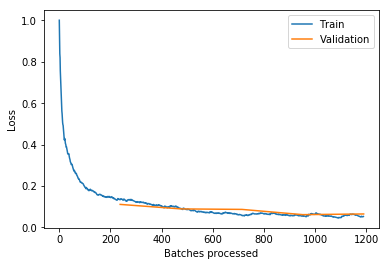

In [61]:
learn.recorder.plot_losses()

In [62]:
learn.save(f'gs-{arch.__name__}-stage1.fai')

In [63]:
learn.load(f'gs-{arch.__name__}-stage1.fai');

In [64]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


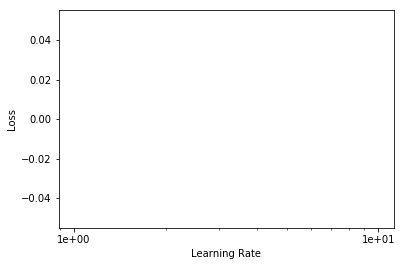

In [66]:
learn.lr_find(); learn.recorder.plot()

In [68]:
div = 100
lr/div, np.log10(lr/div)

(3e-05, -4.522878745280337)

In [69]:
learn.fit_one_cycle(5, slice(1e-6, lr/div))

epoch,train_loss,valid_loss,accuracy
1,0.060501,0.057486,0.980089
2,0.052868,0.052855,0.982971
3,0.042879,0.058296,0.980875
4,0.042722,0.057004,0.981399
5,0.046883,0.050648,0.985329


In [70]:
learn.save(f'gs-{arch.__name__}-stage2.fai')

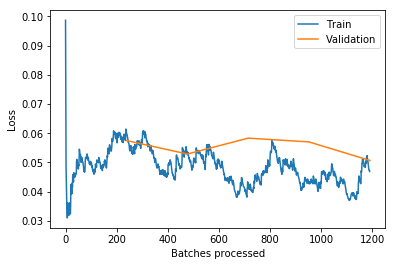

In [71]:
learn.recorder.plot_losses()

In [85]:
%%time
valid_preds, valid_targets = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 22.2 s, sys: 4.53 s, total: 26.7 s
Wall time: 27.4 s


In [84]:
valid_preds.shape[0] / 28

136.32142857142858

### Full Size Images Fine-Tuning

In [141]:
learn.load('gs-rn34-stage2.fai');

In [135]:
data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='border')
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [136]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


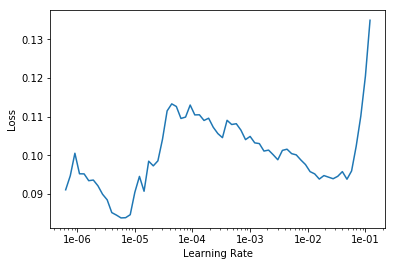

In [137]:
learn.lr_find(); learn.recorder.plot()

In [142]:
lr = 1e-3
lr, np.log10(lr)

(0.001, -3.0)

In [16]:
learn.fit_one_cycle(5, slice(lr))

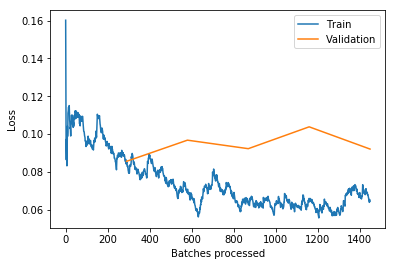

In [144]:
learn.recorder.plot_losses()

In [145]:
lr/10

0.0001

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, lr/10))

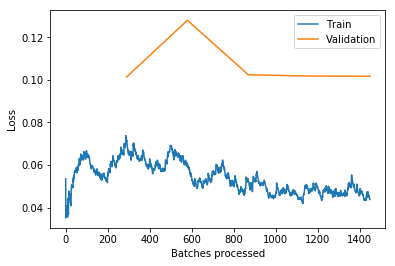

In [147]:
learn.recorder.plot_losses()

### Metrics and Interpretation

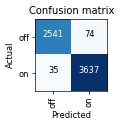

In [438]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

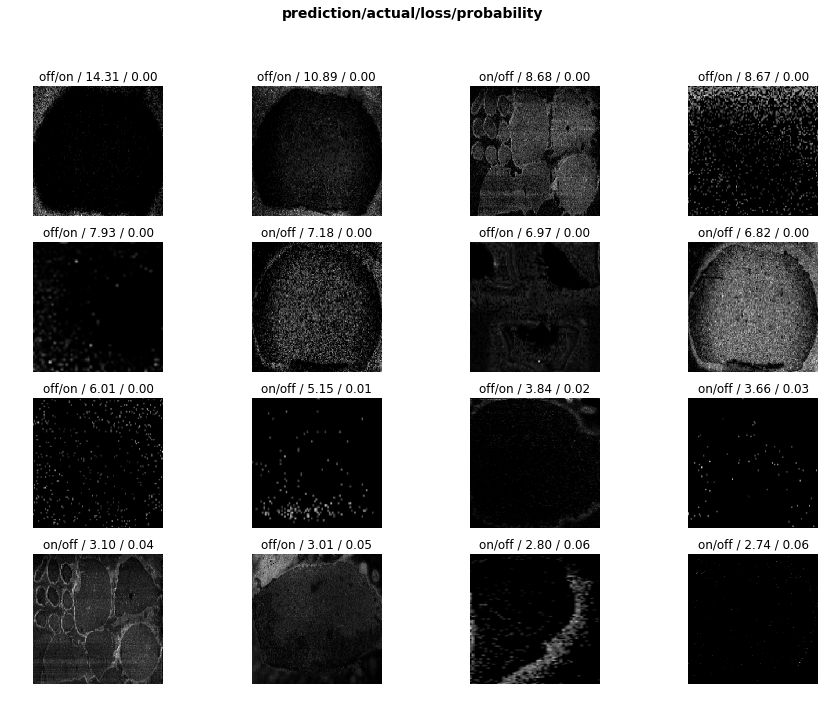

In [439]:
interp.plot_top_losses(16, figsize=(15, 11))

# Cross Validation

### Rect and Non-rect Together

In [24]:
from sklearn.model_selection import GroupKFold

image_df = df

folds = 5  # number of CV folds
cv_metrics = []
ds_metrics = []

def add_metrics(learn, valid_df, fold_i, rect):
    y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)
    metrics = calc_metrics(y_true.numpy(), y_pred.numpy())
    metrics['fold'] = fold_i
    cv_metrics.append(metrics)
    print(metrics)
    ds_metrics.append(calc_ds_metrics(valid_df, y_true, y_pred))

cv_iter = GroupKFold(n_splits=folds).split(image_df.name, groups=image_df.group)
for fold_i, (t_inds, v_inds) in enumerate(cv_iter):
    print(f'Fold: {fold_i}')

    src = (ImageItemList.from_df(image_df, '', cols=0)
           .split_by_idxs(t_inds, v_inds)
           .label_from_df(cols=2))

    tfms = get_transforms(flip_vert=True)
    data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
            .databunch().normalize(imagenet_stats))

    arch = models.resnet50
    learn = create_cnn(data, arch, metrics=[accuracy], ps=0.5)

    print('First round: head training')
    lr = 3e-3
    learn.fit_one_cycle(5, slice(lr), wd=0.1)

    print('Second round: fine-tuning')
    learn.unfreeze()
    div = 10
    learn.fit_one_cycle(5, slice(1e-5, lr/div), wd=0.1)

    add_metrics(learn, image_df.iloc[v_inds], fold_i, rect=True)

cv_metrics_df = pd.concat(cv_metrics)
ds_metrics_df = pd.concat(ds_metrics)

Fold: 0
First round: head training


epoch,train_loss,valid_loss,accuracy
1,0.143148,0.268215,0.913147
2,0.105867,0.135787,0.950000
3,0.084160,0.097571,0.966379


KeyboardInterrupt: 

In [21]:
cv_metrics_df.groupby([cv_metrics_df.index]).agg([np.mean, np.std])

f1                prec              recall                 acc  \
         mean       std      mean       std      mean       std      mean   
off  0.970932  0.005894  0.961989  0.017145  0.980422  0.015093  0.966081   
on   0.956637  0.018119  0.973997  0.014092  0.940477  0.034016  0.966081   

              fold            
          std mean       std  
off  0.009449    2  1.581139  
on   0.009449    2  1.581139

In [26]:
ds_metrics_df

,f1,prec,recall,acc,ds_name
on,1.000000,1.000000,1.000000,1.000000,161007_WT1S1L1
off,1.000000,1.000000,1.000000,1.000000,161007_WT1S1L1
on,0.905660,1.000000,0.827586,0.929178,170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r
off,0.943311,0.892704,1.000000,0.929178,170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r
on,0.994012,0.988095,1.000000,0.991453,2017023_ADP_GFlarvae_55x55_40x40_DMAN002
off,0.985075,1.000000,0.970588,0.991453,2017023_ADP_GFlarvae_55x55_40x40_DMAN002
on,0.928910,1.000000,0.867257,0.959569,20180220_mouse eye_DHB
off,0.971751,0.945055,1.000000,0.959569,20180220_mouse eye_DHB
on,0.993421,0.993421,0.993421,0.994083,50%meoh_8cyc_75um
off,0.994624,0.994624,0.994624,0.994083,50%meoh_8cyc_75um


### Rect and Non-rect Separately

In [350]:
from sklearn.model_selection import GroupKFold

image_df = df

folds = 5  # number of CV folds
cv_metrics = []
ds_metrics = []

def add_metrics(learn, valid_df, fold_i, rect):
    y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)
    metrics = calc_metrics(y_true.numpy(), y_pred.numpy())
    metrics['fold'] = fold_i
    metrics['rect'] = rect
    cv_metrics.append(metrics)
    print(metrics)
    ds_metrics.append(calc_ds_metrics(valid_df, y_true, y_pred))

rect_df = image_df[image_df.rect == True]
nonrect_df = image_df[image_df.rect == False]

cv_iter = zip(GroupKFold(n_splits=folds).split(rect_df.name, groups=rect_df.group),
              GroupKFold(n_splits=folds).split(nonrect_df.name, groups=nonrect_df.group))
for fold_i, ((t_inds, v_inds), (t_inds_2, v_inds_2)) in enumerate(cv_iter):
    print(f'Fold: {fold_i}')

    src = (ImageItemList.from_df(rect_df, '', cols=0)
           .split_by_idxs(t_inds, v_inds)
           .label_from_df(cols=2))
    src_2 = (ImageItemList.from_df(nonrect_df, '', cols=0)
             .split_by_idxs(t_inds_2, v_inds_2)
             .label_from_df(cols=2))

    tfms = get_transforms(flip_vert=True)
    data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
            .databunch().normalize(imagenet_stats))
    data_2 = (src_2.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
              .databunch().normalize(imagenet_stats))

    arch = models.resnet50
    learn = create_cnn(data, arch, metrics=[accuracy], ps=0.5)

    print('First round: head training')
    lr = 3e-3
    learn.fit_one_cycle(5, slice(lr), wd=0.1)

    print('Second round: fine-tuning')
    learn.unfreeze()
    div = 10
    learn.fit_one_cycle(5, slice(1e-5, lr/div), wd=0.1)

    add_metrics(learn, rect_df.iloc[v_inds], fold_i, rect=True)

    print('Third round: non-rect head training')
    learn = create_cnn(data_2, arch, metrics=[accuracy], ps=0.75)
    learn.load(f'gs-{arch.__name__}-stage2.fai');
    learn.freeze()
    lr = 3e-3
    learn.fit_one_cycle(5, slice(lr), wd=10.0)

    add_metrics(learn, nonrect_df.iloc[v_inds_2], fold_i, rect=False)

cv_metrics_df = pd.concat(cv_metrics)
ds_metrics_df = pd.concat(ds_metrics)

           f1      prec    recall       acc  fold   rect
on   0.970033  0.995444  0.945887  0.969799     4  False
off  0.969560  0.945055  0.995370  0.969799     4  False


In [356]:
cv_metrics_df.groupby([cv_metrics_df.index]).agg([np.mean, np.std])

f1               prec              recall                 acc  \
         mean       std     mean       std      mean       std      mean   
off  0.964898  0.017305  0.95212  0.029331  0.978592  0.017410  0.954983   
on   0.929768  0.060157  0.95887  0.038442  0.905715  0.089893  0.954983   

              fold           rect            
          std mean       std mean       std  
off  0.027243    2  1.490712  0.5  0.527046  
on   0.027243    2  1.490712  0.5  0.527046

In [357]:
cv_metrics_df.groupby([cv_metrics_df.rect, cv_metrics_df.index]).agg([np.mean, np.std])

f1                prec              recall            \
               mean       std      mean       std      mean       std   
rect                                                                    
False off  0.954266  0.012971  0.931460  0.016895  0.978414  0.016343   
      on   0.892876  0.065579  0.947399  0.043886  0.847540  0.094295   
True  off  0.975531  0.014931  0.972780  0.024150  0.978770  0.020367   
      on   0.966660  0.020956  0.970340  0.032713  0.963889  0.028799   

                acc           fold            
               mean       std mean       std  
rect                                          
False off  0.937960  0.025447    2  1.581139  
      on   0.937960  0.025447    2  1.581139  
True  off  0.972005  0.017259    2  1.581139  
      on   0.972005  0.017259    2  1.581139

In [17]:
# ds_metrics_df

---